# Exercise 1

First we install meshio to read our .inp mesh file.

In [1]:
!pip install meshio

   ---------------------------------------- 0.0/166.2 kB ? eta -:--:--
   --------------------------------------  163.8/166.2 kB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 166.2/166.2 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/240.7 kB ? eta -:--:--
   --------------------------------------  235.5/240.7 kB 14.1 MB/s eta 0:00:01
   --------------------------------------  235.5/240.7 kB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 240.7/240.7 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/87.5 kB ? eta -:--:--
   ------------------------------------- -- 81.9/87.5 kB 4.8 MB/s eta 0:00:01
   ------------------------------------- -- 81.9/87.5 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 87.5/87.5 kB 552.1 kB/s eta 0:00:00


Next we import our mesh for a circle with radius of $r = 1$. The plot of the mesh is provided below:

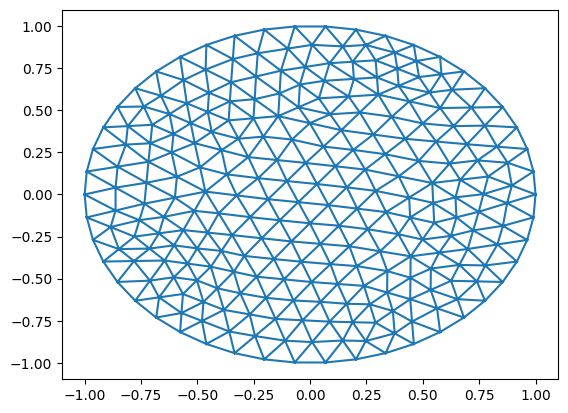

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.spatial
import matplotlib.pyplot as plt
import meshio

# read the mesh from a file
mio = meshio.read('mesh/circle.inp')
p = mio.points.T[:2]
t = mio.cells[-1].data.T

# visualize the mesh
plt.triplot(p[0], p[1], t.T)

From assignment week 2 we have proven that:

\begin{equation}
J = \frac{T}{G\theta} = \frac{2}{G\theta}\iint_{A}\phi\,dA
\end{equation}

By letting $2G\theta=1$ we can see that the torsional rigidity is $J = 4\iint_{A}\phi\,dA$. Therefore, the aim of this code is to solve the following stress equation:

\begin{equation}
-\Delta\phi=1
\end{equation}

for $\phi=0$ on the boundary $\partial{S}$. The code below implements the FEM solver with the Dirictlet condition on the boundary.

Text(0.5, 1.0, 'Stress function')

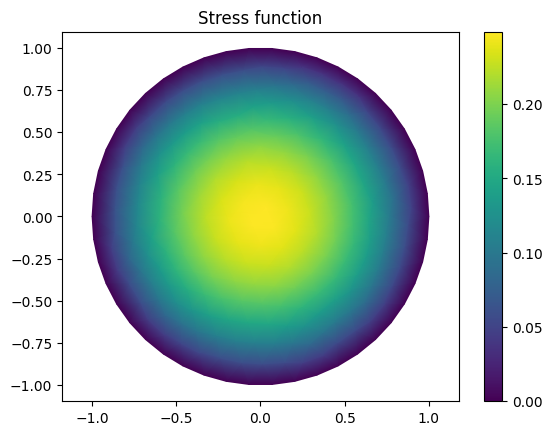

In [4]:
# create affine mappings for all elements
A = p[:, t[[1, 2]]] - p[:, t[0]][:, None]
detA = A[0, 0] * A[1, 1] - A[1, 0] * A[0, 1]
invAT = 1 / detA * np.array([[A[1, 1], -A[1, 0]],
        [-A[0, 1], A[0, 0]]])

# find basis function gradients for all elements
dphihat = np.array([[-1, -1], [1, 0], [0, 1]])
dphi = np.einsum('ijk,lj', invAT, dphihat)

# assemble stiffness matrix K and load vector f
data, rows, cols = [], [], []
f = np.zeros(p.shape[1])
for i in range(3):
    v, dv = 1/3, dphi[:, :, i]
    for j in range(3):
        u, du = 1/3, dphi[:, :, j]
        data.append((du[0] * dv[0] + du[1] * dv[1]) * np.abs(detA) / 2)
        rows.append(t[i])
        cols.append(t[j])
    np.add.at(f, t[i], v * np.abs(detA) / 2)
K = sp.coo_matrix((np.hstack(data), (np.hstack(rows), np.hstack(cols)))).tocsr()

# solve linear system
u = np.zeros(K.shape[0])
# using 0.9999999 instead of 1 to avoid numerical approximation
I = np.nonzero((p[0]**2 + p[1]**2 < 0.9999999))[0]  
u[I] = sp.linalg.spsolve(K[I][:, I], f[I])

# plot solution
plt.tripcolor(*p, u, triangles=t.T, shading='gouraud')
plt.colorbar()
plt.axis('equal')
plt.title("Stress function")

We can see that if $u$ is the DOF vector and $f$ is the load vector then the integral can be approximated by:

\begin{equation}
J = 4\iint_{A}\phi\,dA \approx 4f^Tu
\end{equation}

In [4]:
J = 4 * np.dot(f, u)
J

1.5566102097358172

This is the numerical value of the torsional rigidity. We can compare with the analytical value of $\frac{\pi}{2}$ and get the error:

In [5]:
J - np.pi/2

-0.01418611705907935

# Exercise 2

First, we import our mesh for a shaft with length in meters. The plot of the mesh is provided below:

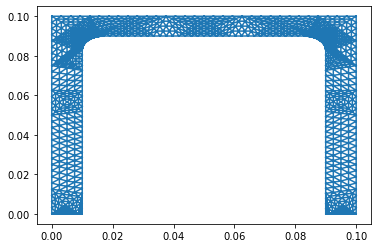

In [6]:
# read the mesh from a file
mio = meshio.read('shaft.inp')
p = mio.points.T[:2]
t = mio.cells[-1].data.T

# visualize the mesh
plt.triplot(p[0], p[1], t.T)

We want to solve $-\Delta\phi=1$ for $\phi=0$ on the boundary $\partial{S}$. The code below implements the FEM solver with the Dirictlet condition on the boundary.

Text(0.5, 1.0, 'Stress function')

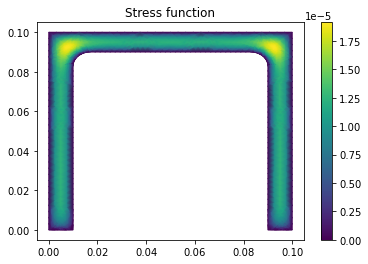

In [7]:
# create affine mappings for all elements
A = p[:, t[[1, 2]]] - p[:, t[0]][:, None]
detA = A[0, 0] * A[1, 1] - A[1, 0] * A[0, 1]
invAT = 1 / detA * np.array([[A[1, 1], -A[1, 0]],
        [-A[0, 1], A[0, 0]]])

# find basis function gradients for all elements
dphihat = np.array([[-1, -1], [1, 0], [0, 1]])
dphi = np.einsum('ijk,lj', invAT, dphihat)

# assemble stiffness matrix K and load vector f
data, rows, cols = [], [], []
f = np.zeros(p.shape[1])
for i in range(3):
    v, dv = 1/3, dphi[:, :, i]
    for j in range(3):
        u, du = 1/3, dphi[:, :, j]
        data.append((du[0] * dv[0] + du[1] * dv[1]) * np.abs(detA) / 2)
        rows.append(t[i])
        cols.append(t[j])
    np.add.at(f, t[i], v * np.abs(detA) / 2)
K = sp.coo_matrix((np.hstack(data), (np.hstack(rows), np.hstack(cols)))).tocsr()

# solve linear system
u = np.zeros(K.shape[0])
# using 0.007001 instead of 0.007 to avoid numerical approximation
I = np.nonzero(((p[0] - 0.017)**2 + (p[1] - 0.083)**2 > 0.007001**2) 
            * ((p[0] - 0.083)**2 + (p[1] - 0.083)**2 > 0.007001**2)
            * (p[0] != 0) * (p[0] != 0.1) * (p[1] != 0) * (p[1] != 0.1)
            * (p[0] != 0.01) * (p[0] != 0.09) * (p[1] != 0.09))[0]  
u[I] = sp.linalg.spsolve(K[I][:, I], f[I])

# plot solution
plt.tripcolor(*p, u, triangles=t.T, shading='gouraud')
plt.colorbar()
plt.title("Stress function")

Using the approximation $J = 4\iint_{A}\phi\,dA \approx 4f^Tu$ we have the torsional rigidity is:

In [8]:
J = 4 * np.dot(f, u)
J

9.380635458573932e-08

Next is the derivation of the twist angle. The twist of the shaft can be calculated as:

\begin{equation}
\theta = \frac{TL}{GJ}
\end{equation}

where $L$ = 1 m is the shaft length. Given $T$ = 500 Nm and $G$ = 79.3 GPa for steel, the twist angle is therefore:

In [9]:
T = 500
G = 79.3*10**9
theta = T/(G*J)
theta

0.06721474539161973

To see if our result converges, we will use a much more refined mesh for the shaft. The code is as following:

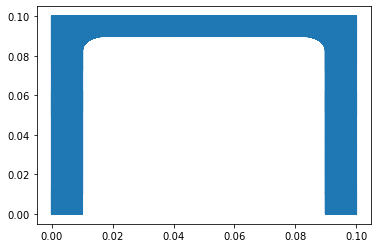

In [10]:
# read the mesh from a file
mio = meshio.read('shaft_refined.inp')
p = mio.points.T[:2]
t = mio.cells[-1].data.T

# visualize the mesh
plt.triplot(p[0], p[1], t.T)

Text(0.5, 1.0, 'Stress function')

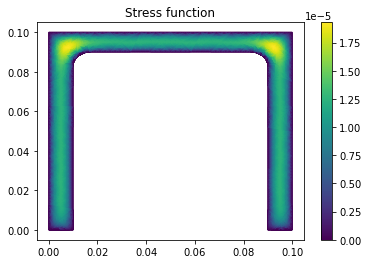

In [11]:
# create affine mappings for all elements
A = p[:, t[[1, 2]]] - p[:, t[0]][:, None]
detA = A[0, 0] * A[1, 1] - A[1, 0] * A[0, 1]
invAT = 1 / detA * np.array([[A[1, 1], -A[1, 0]],
        [-A[0, 1], A[0, 0]]])

# find basis function gradients for all elements
dphihat = np.array([[-1, -1], [1, 0], [0, 1]])
dphi = np.einsum('ijk,lj', invAT, dphihat)

# assemble stiffness matrix K and load vector f
data, rows, cols = [], [], []
f = np.zeros(p.shape[1])
for i in range(3):
    v, dv = 1/3, dphi[:, :, i]
    for j in range(3):
        u, du = 1/3, dphi[:, :, j]
        data.append((du[0] * dv[0] + du[1] * dv[1]) * np.abs(detA) / 2)
        rows.append(t[i])
        cols.append(t[j])
    np.add.at(f, t[i], v * np.abs(detA) / 2)
K = sp.coo_matrix((np.hstack(data), (np.hstack(rows), np.hstack(cols)))).tocsr()

# solve linear system
u = np.zeros(K.shape[0])
# using 0.0070001 instead of 0.007 to avoid numerical approximation
I = np.nonzero(((p[0] - 0.017)**2 + (p[1] - 0.083)**2 > 0.0070001**2) 
            * ((p[0] - 0.083)**2 + (p[1] - 0.083)**2 > 0.0070001**2)
            * (p[0] != 0) * (p[0] != 0.1) * (p[1] != 0) * (p[1] != 0.1)
            * (p[0] != 0.01) * (p[0] != 0.09) * (p[1] != 0.09))[0]  
u[I] = sp.linalg.spsolve(K[I][:, I], f[I])

# plot solution
plt.tripcolor(*p, u, triangles=t.T, shading='gouraud')
plt.colorbar()
plt.title("Stress function")

In [12]:
J = 4 * np.dot(f, u)
T = 500
G = 79.3*10**9
theta = T/(G*J)
theta

0.06451973922365639

We can conclude that the result converges.